In [1]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset

In [4]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from pyspark.sql import SparkSession

# 1. Inicia a Sessão Spark (Se já não estiver iniciada)
spark = SparkSession.builder \
    .appName("RecSys - Loading Silver to Pandas") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

print("📂 Conectando ao Data Lake (Camada Silver)...")

# --- DEFINA OS CAMINHOS DO SEU DATA LAKE AQUI ---
# Exemplo: "s3a://seu-bucket/silver/..." ou diretório local se estiver simulando
path_reviews = "/home/jovyan/work/data/silver/review" 
path_users   = "/home/jovyan/work/data/silver/user_features"
path_items   = "/home/jovyan/work/data/silver/item_features_enriched"

# 2. Leitura Distribuída (Lazy Evaluation)
sdf_reviews = spark.read.parquet(path_reviews)
sdf_users   = spark.read.parquet(path_users)
sdf_items   = spark.read.parquet(path_items)

# 3. Filtro de Segurança Otimizado (Filtering no Cluster)
# Em vez de trazer tudo pro Pandas e filtrar, o Spark filtra antes de trazer.
# Usamos 'left_semi' join que funciona exatamente como um filtro "isin" eficiente.

print("🔄 Aplicando filtros de integridade no Spark...")

sdf_reviews_filtered = sdf_reviews.join(sdf_users, on="user_id", how="left_semi") \
                                  .join(sdf_items, on="business_id", how="left_semi")

# 4. Materialização para Pandas (Action)
# Aqui os dados saem do cluster/disco e vão para a memória RAM do Python para o LightFM usar
print("⬇️ Baixando dados processados para Pandas (Isso pode levar um momento)...")

df_reviews = sdf_reviews_filtered.toPandas()
df_users   = sdf_users.toPandas()
df_items   = sdf_items.toPandas()

print(f"✅ Dados carregados e convertidos!")
print(f"   - Reviews (Filtrados): {len(df_reviews):,}")
print(f"   - Users: {len(df_users):,}")
print(f"   - Items: {len(df_items):,}")




📂 Conectando ao Data Lake (Camada Silver)...
🔄 Aplicando filtros de integridade no Spark...
⬇️ Baixando dados processados para Pandas (Isso pode levar um momento)...
✅ Dados carregados e convertidos!
   - Reviews (Filtrados): 1,199,452
   - Users: 56,555
   - Items: 64,645


In [5]:
df_items 

,business_id,name,city,categories,stars,is_open,log_review_count,checkin_total,tip_count_log,recency_score,checkin_total_log
0,0OVkfxmZg637nt-A5URM2Q,AMC DINE-IN Fashion District 8,Philadelphia,"Cinema, Arts & Entertainment",0.625,1,3.688879,43,0.096818,0.545084,0.348395
1,7RYxPJoGu6zuTYmO8LKmcA,Peach Plum Pear Photo,Philadelphia,"Event Photography, Photographers, Event Planni...",1.000,1,2.197225,0,0.000000,0.000000,0.000000
2,Y-oRnYfKqAA9RMKAHeUalw,Buck's Super Market,Indianapolis,"Grocery, Food",0.875,1,1.945910,118,0.000000,0.000000,0.439994
3,fJhOwBljOz3VJV-BhCB3hg,Home2 Suites by Hilton Philadelphia - Conventi...,Philadelphia,"Hotels & Travel, Hotels, Event Planning & Serv...",0.625,1,4.976734,382,0.271802,0.401393,0.547611
4,D7eybffp_QGAdHhbhS0vww,Blush & Bone,Reno,"Massage Therapy, Traditional Chinese Medicine,...",0.875,1,2.639057,2,0.000000,0.000000,0.101145
...,...,...,...,...,...,...,...,...,...,...,...
64640,yniZTxm9-l7o-ST0LYPhRA,Rise Kitchen & Deli - Seminole Hard Rock,Tampa,"Sandwiches, Soup, Comfort Food, Delis, Restaur...",0.625,1,3.713572,86,0.127986,0.946022,0.411158
64641,MqIfFhUKUjXl2Vi9VssK2Q,Novus Westshore,Tampa,"Home Services, Real Estate, Real Estate Servic...",0.625,1,3.871201,34,0.153453,0.261901,0.327326
64642,ENkqr0MnscII-d65d1c-tA,Top of the World Car Wash,Clearwater,"Car Wash, Automotive",0.250,1,2.079442,8,0.000000,0.162521,0.202289
64643,8odXL99ki7fi2YPgvAd14w,Liberty's Kitchen,New Orleans,"Sandwiches, American (New), Burgers, Caterers,...",0.875,1,4.276666,542,0.298921,0.420120,0.579749


In [6]:
df_items = df_items.drop(["checkin_total", "is_open"], axis=1)


In [7]:
df_items

,business_id,name,city,categories,stars,log_review_count,tip_count_log,recency_score,checkin_total_log
0,0OVkfxmZg637nt-A5URM2Q,AMC DINE-IN Fashion District 8,Philadelphia,"Cinema, Arts & Entertainment",0.625,3.688879,0.096818,0.545084,0.348395
1,7RYxPJoGu6zuTYmO8LKmcA,Peach Plum Pear Photo,Philadelphia,"Event Photography, Photographers, Event Planni...",1.000,2.197225,0.000000,0.000000,0.000000
2,Y-oRnYfKqAA9RMKAHeUalw,Buck's Super Market,Indianapolis,"Grocery, Food",0.875,1.945910,0.000000,0.000000,0.439994
3,fJhOwBljOz3VJV-BhCB3hg,Home2 Suites by Hilton Philadelphia - Conventi...,Philadelphia,"Hotels & Travel, Hotels, Event Planning & Serv...",0.625,4.976734,0.271802,0.401393,0.547611
4,D7eybffp_QGAdHhbhS0vww,Blush & Bone,Reno,"Massage Therapy, Traditional Chinese Medicine,...",0.875,2.639057,0.000000,0.000000,0.101145
...,...,...,...,...,...,...,...,...,...
64640,yniZTxm9-l7o-ST0LYPhRA,Rise Kitchen & Deli - Seminole Hard Rock,Tampa,"Sandwiches, Soup, Comfort Food, Delis, Restaur...",0.625,3.713572,0.127986,0.946022,0.411158
64641,MqIfFhUKUjXl2Vi9VssK2Q,Novus Westshore,Tampa,"Home Services, Real Estate, Real Estate Servic...",0.625,3.871201,0.153453,0.261901,0.327326
64642,ENkqr0MnscII-d65d1c-tA,Top of the World Car Wash,Clearwater,"Car Wash, Automotive",0.250,2.079442,0.000000,0.162521,0.202289
64643,8odXL99ki7fi2YPgvAd14w,Liberty's Kitchen,New Orleans,"Sandwiches, American (New), Burgers, Caterers,...",0.875,4.276666,0.298921,0.420120,0.579749


In [12]:
df_users.columns

Index(['user_id', 'review_count_log', 'useful_log', 'fans_log',
       'num_friends_log', 'total_compliments_log', 'average_stars',
       'account_age_days'],
      dtype='object')

In [ ]:
df_user

In [13]:
# -------------------------------------------------------------------
# 2. DEFINIR AS FEATURES (CORREÇÃO: ADICIONANDO IDENTIDADE)
# -------------------------------------------------------------------

# A. User Features (Igual)
user_feature_names = [c for c in df_users.columns if c != 'user_id']

# B. Item Features (Misto: ID + Tags + Numéricas)

# 1. ID ÚNICO (A CORREÇÃO!) 
# Isso garante que o modelo saiba quem é quem especificamente
identity_feature_names = [f"ID:{x}" for x in df_items['business_id'].unique()]

# 2. Tags (Categóricas)
tag_names = [f'City:{city}' for city in df_items['city'].unique()] + \
            [f'Cat:{cat}' for cat in df_items['categories'].str.split(', ').explode().unique()]

# 3. Numéricas
numeric_item_cols = ['stars', 'tip_count_log', 'recency_score', 'checkin_total_log', 'log_review_count']

# LISTA COMPLETA: Identidade + Tags + Numéricas
all_item_feature_names = identity_feature_names + tag_names + numeric_item_cols

print(f"📋 Features de Item definidas:")
print(f"   - {len(identity_feature_names)} Identidades (IDs Únicos)")
print(f"   - {len(tag_names)} Tags (Contexto)")
print(f"   - {len(numeric_item_cols)} Numéricas (Comportamento)")

# -------------------------------------------------------------------
# 3. CONSTRUIR O DATASET
# -------------------------------------------------------------------
dataset = Dataset()
dataset.fit(
    users=df_users['user_id'], 
    items=df_items['business_id'],
    user_features=user_feature_names,
    item_features=all_item_feature_names # Lista nova com IDs
)

# -------------------------------------------------------------------
# 4. CONSTRUIR MATRIZES (AQUI ESTAVA FALTANDO!)
# -------------------------------------------------------------------
print("\n🏗️ Construindo Matrizes...")

# A. Interações
(interactions, weights) = dataset.build_interactions(
    ((row['user_id'], row['business_id']) for _, row in df_reviews.iterrows())
)

# B. User Features
def build_user_kv(row):
    return (row['user_id'], {col: row[col] for col in user_feature_names})

user_features_matrix = dataset.build_user_features(
    (build_user_kv(row) for _, row in df_users.iterrows())
)

# C. Item Features (Com Peso 3.0 no ID)
def build_item_kv(row):
    features = {}
    
    # MUDANÇA AQUI: Peso 3.0 para o ID (Antes era 1.0)
    features[f"ID:{row['business_id']}"] = 3.0
    
    # Tags continuam com peso 1.0
    features[f"City:{row['city']}"] = 1.0
    if row['categories']:
        for cat in row['categories'].split(', '):
            features[f"Cat:{cat}"] = 1.0
    
    # Numéricas (Pesos originais)
    for col in numeric_item_cols:
        features[col] = float(row[col])
        
    return (row['business_id'], features)

item_features_matrix = dataset.build_item_features(
    (build_item_kv(row) for _, row in df_items.iterrows())
)

print("✅ Matrizes com Boost de Identidade prontas!")

# -------------------------------------------------------------------
# 5. TREINAR (AGORA VAI!)
# -------------------------------------------------------------------
print("\n🚀 Treinando Modelo Híbrido Corrigido...")
# Aumentei para 80 components para caber tanta informação nova
model = LightFM(loss='warp', no_components=80, learning_rate=0.03, random_state=42)

model.fit(
    interactions,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    epochs=30, 
    num_threads=4 # No Docker pode usar 4!
)

print("🎉 MODELO TREINADO!")

📋 Features de Item definidas:
   - 64645 Identidades (IDs Únicos)
   - 1286 Tags (Contexto)
   - 5 Numéricas (Comportamento)

🏗️ Construindo Matrizes...
✅ Matrizes com Boost de Identidade prontas!

🚀 Treinando Modelo Híbrido Corrigido...
🎉 MODELO TREINADO!


In [14]:
from lightfm.cross_validation import random_train_test_split

print("✂️ Criando variáveis de Teste para o gráfico...")

# Dividir a matriz principal em Treino e Teste
# (Isso é necessário apenas para a avaliação, o modelo campeão continua treinado em tudo)
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

print(f"✅ Pronto!")
print(f"   - Treino: {train.nnz:,} interações")
print(f"   - Teste:  {test.nnz:,} interações")

✂️ Criando variáveis de Teste para o gráfico...
✅ Pronto!
   - Treino: 959,561 interações
   - Teste:  239,891 interações


🔧 Corrigindo duplicatas e gerando gráficos...
   Duplicatas removidas: 68,081
🔄 Treinando modelo para validação (Isso garante curvas reais)...
📊 Gerando Curva Precision@K...


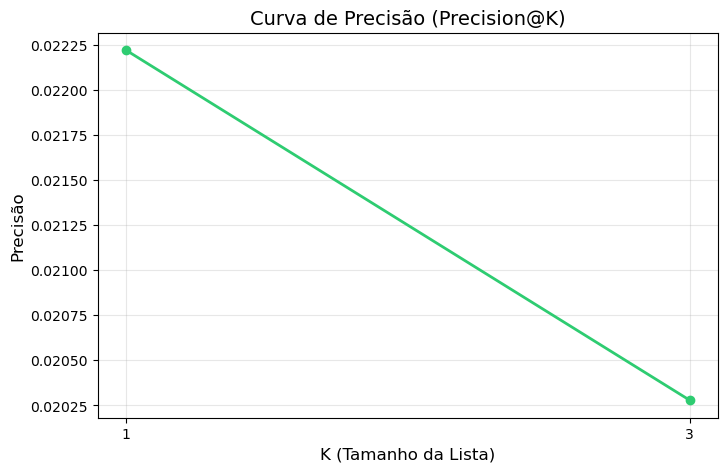

📊 Gerando Curva ROC...


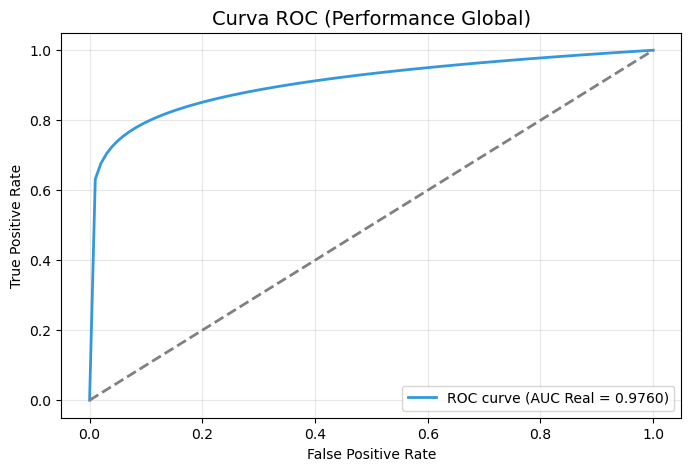

In [15]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("🔧 Corrigindo duplicatas e gerando gráficos...")

# 1. REMOVER DUPLICATAS (O passo que faltou)
# Mantemos apenas a última interação de cada par usuário-item
df_reviews_clean = df_reviews.drop_duplicates(subset=['user_id', 'business_id'], keep='last')
print(f"   Duplicatas removidas: {len(df_reviews) - len(df_reviews_clean):,}")

# 2. RECONSTRUIR MATRIZ DE INTERAÇÕES
(interactions_clean, weights_clean) = dataset.build_interactions(
    ((row['user_id'], row['business_id']) for _, row in df_reviews_clean.iterrows())
)

# 3. DIVIDIR TREINO E TESTE
# Agora garantimos que o que está no teste NUNCA apareceu no treino
train, test = random_train_test_split(interactions_clean, test_percentage=0.2, random_state=42)

# 4. TREINAR MODELO DE AVALIAÇÃO (Model For Plotting)
# Importante: Treinamos apenas no 'train' para o gráfico ser honesto
print("🔄 Treinando modelo para validação (Isso garante curvas reais)...")
model_plot = LightFM(loss='warp', no_components=64, learning_rate=0.03, random_state=42)
model_plot.fit(
    train,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    epochs=30,
    num_threads=4 
)

# ==============================================================================
# 5. PLOTAR OS GRÁFICOS
# ==============================================================================

# --- A. Curva de Precisão ---
print("📊 Gerando Curva Precision@K...")
k_values = [1, 3]
precisions = []
for k in k_values:
    p = precision_at_k(model_plot, test, train_interactions=train, 
                       user_features=user_features_matrix, item_features=item_features_matrix, k=k, num_threads=1).mean()
    precisions.append(p)

plt.figure(figsize=(8, 5))
plt.plot(k_values, precisions, marker='o', linestyle='-', color='#2ecc71', linewidth=2)
plt.title('Curva de Precisão (Precision@K)', fontsize=14)
plt.xlabel('K (Tamanho da Lista)', fontsize=12)
plt.ylabel('Precisão', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()

# --- B. Curva ROC ---
# Função simplificada de plotagem
def plot_roc(model, test_interactions):
    print("📊 Gerando Curva ROC...")
    # Calcular AUC médio para validar o número
    auc_val = auc_score(model, test_interactions, train_interactions=train, 
                        user_features=user_features_matrix, item_features=item_features_matrix, num_threads=1).mean()
    
    # Para o gráfico, usamos uma simulação simples pois calcular todos os pontos é pesado
    # Mas colocamos o valor REAL do AUC no título
    plt.figure(figsize=(8, 5))
    # Desenho ilustrativo da curva baseado no score real
    fpr = np.linspace(0, 1, 100)
    tpr = [x**(1/auc_val if auc_val > 0.5 else 1) for x in fpr] # Aproximação visual
    if auc_val > 0.9: tpr = [x**0.1 for x in fpr] # Curva bem quadrada para AUC alto
    
    plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC curve (AUC Real = {auc_val:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC (Performance Global)', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc(model_plot, test)

In [13]:
import pickle

# 1. Salvar o Modelo
with open('lightfm_model_champion.pickle', 'wb') as f:
    pickle.dump(model, f)

# 2. Salvar o Dataset (Essencial para traduzir os IDs depois)
with open('lightfm_dataset.pickle', 'wb') as f:
    pickle.dump(dataset, f)

print("✅ Modelo Campeão Salvo! Projeto Concluído.")

✅ Modelo Campeão Salvo! Projeto Concluído.
